In [1]:
%config InlineBackend.figure_formats = ['svg']
import quimb.tensor as qtn
import quimb as qu
import cotengra as ctg
import autoray as ar
import register_ as reg
import algo_cooling as algo
import quf
import time
import numpy as np
from quimb.tensor.belief_propagation.l2bp import L2BP
from tqdm import tqdm
import gate_arb
from gate_arb import TensorNetworkGenVector
import torch

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use(qu.NEUTRAL_STYLE)

In [2]:
reg.reg_complex_svd()
# reg.reg_complex_svd_jax()

to_backend = algo.backend_torch(device = "cpu", dtype = torch.complex128, requires_grad=False)
to_backend_c = algo.backend_torch(device = "cpu", dtype = torch.complex128, requires_grad=False)

# high quality: max_time="equil:128",max_repeats=2**10, optlib=nevergrad
# terminate search if contraction is cheap: "rate:1e9"
opt = algo.opt_(progbar=False, max_time="rate:1e9", max_repeats=128, optlib="cmaes")

# opt ='random-greedy-128'

In [3]:
info_su = {}

In [4]:
#ITF params and Unitary
J = 1
h = 3.05
dt, t = 0.05, 0
info_su |= {"h":h, "J":J, "dt":dt, }

h2 = -J * qu.pauli("Z") & qu.pauli("Z")
h1 = -h * qu.pauli("X")

U2 = ar.do("linalg.expm", -1j * dt * h2)
U1 = ar.do("linalg.expm", -1j * dt * h1 / 2)
U1_ = ar.do("linalg.expm", -1j * dt * h1 )

In [5]:
Lx, Ly = 8, 8
L = Lx * Ly
edges = qtn.edges_2d_square(Lx=Lx, Ly=Ly, cyclic=False)
info_su |= {"Lx":Lx, "Ly":Ly, "L":L, }


In [6]:
# --- coordinate maps ---
map_1d_to_2d = {j * Lx + i: (i, j) for j in range(Ly) for i in range(Lx)}
map_2d_to_1d = {(i, j): j * Lx + i for j in range(Ly) for i in range(Lx)}

# --- tag and index maps ---
map_tags  = {f"I{i},{j}": f"I{map_2d_to_1d[(i, j)]}" for j in range(Ly) for i in range(Lx)}
map_tags_2d  = {f"I{map_2d_to_1d[(i, j)]}":f"I{i},{j}" for j in range(Ly) for i in range(Lx)}

# notice b--->k as U_bk ~ pepo_kb 
map_inds   = {f"k{i},{j}": f"b{map_2d_to_1d[(i, j)]}" for j in range(Ly) for i in range(Lx)}
map_inds_b = {f"b{i},{j}": f"k{map_2d_to_1d[(i, j)]}" for j in range(Ly) for i in range(Lx)}


map_inds_2d_k   = { f"b{map_2d_to_1d[(i, j)]}":f"k{i},{j}"  for j in range(Ly) for i in range(Lx)}
map_inds_2d_b = { f"k{map_2d_to_1d[(i, j)]}": f"b{i},{j}" for j in range(Ly) for i in range(Lx)}



# --- site list ---
site_tags = [f"I{n}" for n in range(L)]
sites = sorted({(map_2d_to_1d[site],) for edge in edges for site in edge})
N = len(sites)

# --- remap edges to 1D indexing ---
edges_1d = [(map_2d_to_1d[x], map_2d_to_1d[y]) for x, y in edges]
info_su |= {"edges_1d":edges_1d, "edges":edges, "map_tags":map_tags, "map_inds_b":map_inds_b}
info_su |= {"map_1d_to_2d":map_1d_to_2d, "map_2d_to_1d":map_2d_to_1d, "map_inds":map_inds, "sites":sites}
info_su |= {"site_tags":site_tags, "map_tags_2d":map_tags_2d}
info_su |= {"map_inds_2d_k":map_inds_2d_k, "map_inds_2d_b":map_inds_2d_b}


In [7]:
pepo = quf.pepo_identity(Lx, Ly)
pepo.apply_to_arrays(to_backend_c)

In [8]:
# PEPO to TensorNetworkGenVector
pepo.retag_(map_tags)
pepo.reindex_(map_inds)
pepo.reindex_(map_inds_b)

pepo.view_as_(TensorNetworkGenVector,  site_tag_id='I{}',site_ind_id='k{}',)

TensorNetworkGenVector(tensors=64, indices=240)

In [9]:
# create simple update gauges
gauges = {}
pepo.gauge_all_simple_(max_iterations=1000, tol=1e-6, gauges=gauges, progbar=True,)

max|dS|=0.00e+00, nfact=9.63: : 1it [00:00,  8.96it/s]


TensorNetworkGenVector(tensors=64, indices=240)

In [10]:
# rx gate
rx   = qtn.circuit.rx_gate_param_gen([-h * dt])
# rzz gate
rzz = qtn.circuit.rzz_param_gen([-2 * J * dt])

In [11]:
%%time
chi = 12
depth_total = 10

info_su |= {"chi": chi}
info_su |= {"depth": depth_total}


pbar = tqdm(total=depth_total, desc="SU", ncols=100, dynamic_ncols=True)
results = {"t": [], "Bp_norm": [], "Error": []}

renorm =  True
equilib = False
bp_cal = True

for depth in range(depth_total):

    # advance time
    t += dt    

    # apply RX (two-site) with truncation e(-i X h dt / 2)
    for count, site in enumerate(sites):
        pepo.gate_simple_(to_backend(rx), site, gauges=gauges)

    # apply RZZ (two-site) with truncation e(-i ZZ J dt)
    for where in edges_1d:
        pepo.gate_simple_(to_backend(rzz), where, gauges=gauges, 
                          max_bond=chi, cutoff=1.e-12, 
                          cutoff_mode='rsum2', renorm=renorm
                         )
        
    # apply RX (two-site) with truncation e(-i X h dt / 2)    
    for count, site in enumerate(sites):
        pepo.gate_simple_(to_backend(rx), site, gauges=gauges )


    # equilibrate gauges
    if equilib:
        # ensure gauge is equilibrated
        pepo.gauge_all_simple_(max_iterations=100, tol=1e-6, gauges=gauges, progbar=False,)


    
    results.setdefault("t", []).append(t)




    if bp_cal:
        # build gauged copy for norm/BP
        pepo_ = pepo.copy()
        pepo_.gauge_simple_insert(gauges)

        # boundary propagation norm estimate
        bp = L2BP(pepo_, optimize=opt, site_tags=site_tags)
        bp.run(max_iterations=2_000, tol=1.e-7, progbar=False, diis=True)
        est_norm = complex(bp.contract()).real
        
        # stable norm: 
        log_val = np.log(est_norm) + (2 * complex(pepo.exponent).real * np.log(10)) - (L * np.log(2))
        bpnorm = np.exp(log_val)

        results.setdefault("Bp_norm", []).append(bpnorm)
        results.setdefault("Error", []).append(1  -  (np.log(bpnorm) / L))


    


    
    # update progress (guard against None/unused vars)
    pbar.set_postfix({
        "t":       f"{round(t,2)}",
        "Bp_norm":  "—" if not len(results["Bp_norm"]) else round(bpnorm, 4),
        "Error":  "—" if not len(results["Error"]) else round(bpnorm, 4),

    })
    pbar.update(1)

pbar.close()



SU: 100%|███████████████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.53s/it, t=0.5, Bp_norm=1, Error=1]

CPU times: user 8min 19s, sys: 2.29 s, total: 8min 22s
Wall time: 15.3 s


In [12]:
tn = pepo.copy()
_, _ = tn.gauge_simple_insert(gauges)
tn.reindex_( map_inds_2d_k )
tn.reindex_( map_inds_2d_b )


# norm = (tn.H & tn).contract(all, optimize=opt)
# print(complex(norm).real, 2**L, complex(norm).real /  2**L )

TensorNetworkGenVector(tensors=64, indices=240)

In [13]:

info_su |= {"gauges":gauges, "pepo":pepo, "map_inds":map_inds, "sites":sites}
info_su |= {"tn":tn}
info_su |= {"chi":chi}

qu.save_to_disk(info_su, "store_state/info_su")


['store_state/info_su']

In [14]:
# results["Error"][-1],  results["bpnorm"][-1]

In [15]:
tn = pepo.copy()
tn.gauge_simple_insert(gauges)

bp = L2BP(tn, optimize=opt, site_tags=site_tags)
bp.run(max_iterations=420, tol=1.e-7, progbar=False, diis=True)
est_norm = complex(bp.contract()).real

log_val = np.log(est_norm) + (2 * complex(tn.exponent).real * np.log(10)) - (L * np.log(2))
bpnorm = np.exp(log_val)
bpnorm


0.9999999016563428

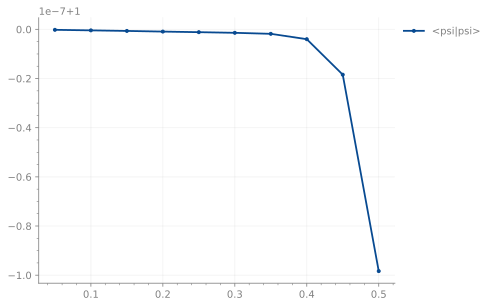

In [16]:
if results["Bp_norm"]:
    plt.plot(
        results["t"],
        results["Bp_norm"],
        ".-",
        label=f"<psi|psi>",
        color=mpl.cm.Blues((8 + 1) / 10),
        linewidth=2 * (8 + 1) / 10,
    )
    
    
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()
    plt.close()

In [17]:
results["Bp_norm"]

[0.9999999998133546,
 0.9999999995892423,
 0.9999999993611652,
 0.9999999990945625,
 0.9999999988539018,
 0.999999998594852,
 0.9999999981837108,
 0.99999999599968,
 0.999999981567335,
 0.9999999016563428]

In [18]:
# mpo = quf.mpo_ITF_2d(Lx, Ly, data_type="float64", chi=200, cutoff_val=1.0e-12, field=h, sign="-", print_=False)
# inds_k = [ f"k{i}"  for i in range(L)]
# inds_b = [ f"b{i}"  for i in range(L)]

# Ham_ = np.array(mpo.to_dense(inds_k, inds_b), dtype="complex128")

# print("t", t)
# U_matrix = ar.do("linalg.expm", -1j * Ham_ * t)
# U_matrix = to_backend_c(U_matrix)
# print("U shape:", U_matrix.shape, t)
# print("Unitary?", np.allclose(U_matrix.conj().T @ U_matrix, np.eye(Ham_.shape[0])))

In [19]:
# pepo_m = tn.to_dense(inds_b, inds_k)

In [20]:
# F = algo.gate_fidelity(pepo_m, U_matrix)
# print("F=", F, 1 - F)
# # 8.389656432405967e-05

In [21]:
# pepo_t = quf.pepo_trotter_ITF(edges, Lx=Lx, Ly=Ly, to_backend=to_backend_c, h=h, J=J, delta=0.5)
# # pepo_t = quf.pepo_trotter_ITF_fourth(edges, Lx=Lx, Ly=Ly, to_backend=to_backend_c, h=h, J=J, delta=0.5)

# pepo_t.reindex_(map_inds)
# pepo_t.reindex_(map_inds_b)

# pepo_m_ = pepo_t.to_dense(inds_b, inds_k)

In [22]:
# F = algo.gate_fidelity(pepo_m_, U_matrix)
# print("F=", F, 1 - F)


In [23]:
# F = algo.gate_fidelity(pepo_m_, pepo_m)
# print("F=", F, 1 - F)


In [24]:
# #pepo_t = quf.pepo_trotter_ITF(edges, Lx=Lx, Ly=Ly, to_backend=to_backend_c, h=h, J=J, delta=0.5)
# print(h, J)
# pepo_t = quf.pepo_trotter_ITF_fourth(edges, Lx=Lx, Ly=Ly, to_backend=to_backend_c, h=h, J=J, delta=0.5)

# pepo_t.reindex_(map_inds)
# pepo_t.reindex_(map_inds_b)

# pepo_m_ = pepo_t.to_dense(inds_b, inds_k)

In [25]:
# F = algo.gate_fidelity(pepo_m_, U_matrix)
# print("F=", F, 1 - F)

# F = algo.gate_fidelity(pepo_m_, pepo_m)
# print("F=", F, 1 - F)
